<a href="https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/Brain_parcellation_with_TorchIO_and_HighRes3DNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain parcellation with TorchIO and HighRes3DNet

We are going to perform a full brain parcellation of a 3D T1-weighted MRI using [TorchIO](https://torchio.readthedocs.io/) and a pre-trained [PyTorch](https://pytorch.org/) deep learning model in less than 50 lines of code and less than two minutes.

## TorchIO

TorchIO is a Python package to prepare 3D medical images for deep learning pipelines. Check out the [documentation](https://torchio.readthedocs.io/) and a longer [Colab notebook](https://colab.research.google.com/drive/112NTL8uJXzcMw4PQbUvMQN-WHlVwQS3i) containing many examples.

## HighRes3DNet

HighRes3DNet is a 3D residual network presented by Li et al. in [On the Compactness, Efficiency, and Representation of 3D Convolutional Networks: Brain Parcellation as a Pretext Task](https://link.springer.com/chapter/10.1007/978-3-319-59050-9_28). The authors shared the weights of the model they trained to perform full brain parcellation as in [Geodesic Information Flows: Spatially-Variant Graphs and Their Application to Segmentation and Fusion](https://spiral.imperial.ac.uk/bitstream/10044/1/30755/4/07086081.pdf), also known as GIF parcellation.

The weights were ported from TensorFlow as shown in [this entry to the MICCAI educational challenge 2019](https://github.com/fepegar/miccai-educational-challenge-2019).

First we will install TorchIO and download a couple of useful files:

In [1]:
!pip install --quiet torchio==0.18.90
!pip install --quiet pandas matplotlib seaborn scikit-image
!curl -sS -O https://raw.githubusercontent.com/fepegar/highresnet/master/GIFNiftyNet.ctbl

In [2]:
import datetime
from functools import partialmethod
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchio as tio
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm, trange


torch.manual_seed(0)
torch.set_grad_enabled(False)
figsize = 16, 9
tio.Subject.plot = partialmethod(tio.Subject.plot, figsize=figsize, reorient=False)

print('TorchIO version:', tio.__version__)
print('Last run:', datetime.date.today())

TorchIO version: 0.18.90
Last run: 2023-04-16


## Preparing the data

Let's download a T1-weighted MRI hosted on the NiftyNet model zoo:

In [3]:
root_dir = Path('data')
tio.download.download_and_extract_archive(
    'https://github.com/NifTK/NiftyNetModelZoo/raw/5-reorganising-with-lfs/highres3dnet_brain_parcellation/data.tar.gz',
    root_dir
)
mri_path = list(root_dir.glob('*.nii.gz'))[0]
mri_path

PosixPath('data/OAS1_0145_MR2_mpr_n4_anon_sbj_111.nii.gz')

We will now create an instance of [`torchio.ScalarImage`](https://torchio.readthedocs.io/data/image.html#torchio.ScalarImage) and pass it to a [`torchio.Subject`](https://torchio.readthedocs.io/data/subject.html):

In [4]:
subject_oasis = tio.Subject(t1=tio.ScalarImage(mri_path))
subject = subject_oasis

We are going to apply four [preprocessing transforms](https://torchio.readthedocs.io/transforms/preprocessing.html) to our instance of `Subject`:

1. [`ToCanonical`](https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.ToCanonical) reorients our image using [NiBabel](https://nipy.org/nibabel/) so that it is in [RAS+ orientation](https://nipy.org/nibabel/image_orientation.html)
2. [`Resample`](https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.Resample) changes the voxels spacing using [SimpleITK](https://simpleitk.org/). This is analogous to using [`torchvision.transforms.Resize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize)
3. [`ZNormalization`](https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.ZNormalization) generates an image with zero mean and unit variance. Normalization transforms in medical imaging typically use only the foreground values (computed as the values above the mean intensity) to calculate the corresponding statistics
4. [`Crop`](https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.Crop) reduces the field of view by removing voxels from the image. This will make our computations slightly faster.

In [5]:
transforms = [
    tio.ToCanonical(),
    tio.Resample(1),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.Crop((0, 0, 10, 30, 40, 40)),
]
transform = tio.Compose(transforms)
preprocessed = transform(subject)

The transforms are chained together using [`torchio.Compose`](https://torchio.readthedocs.io/transforms/augmentation.html#compose). As you can see, the interface is similar to [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html). Let's take a look at the input volume:

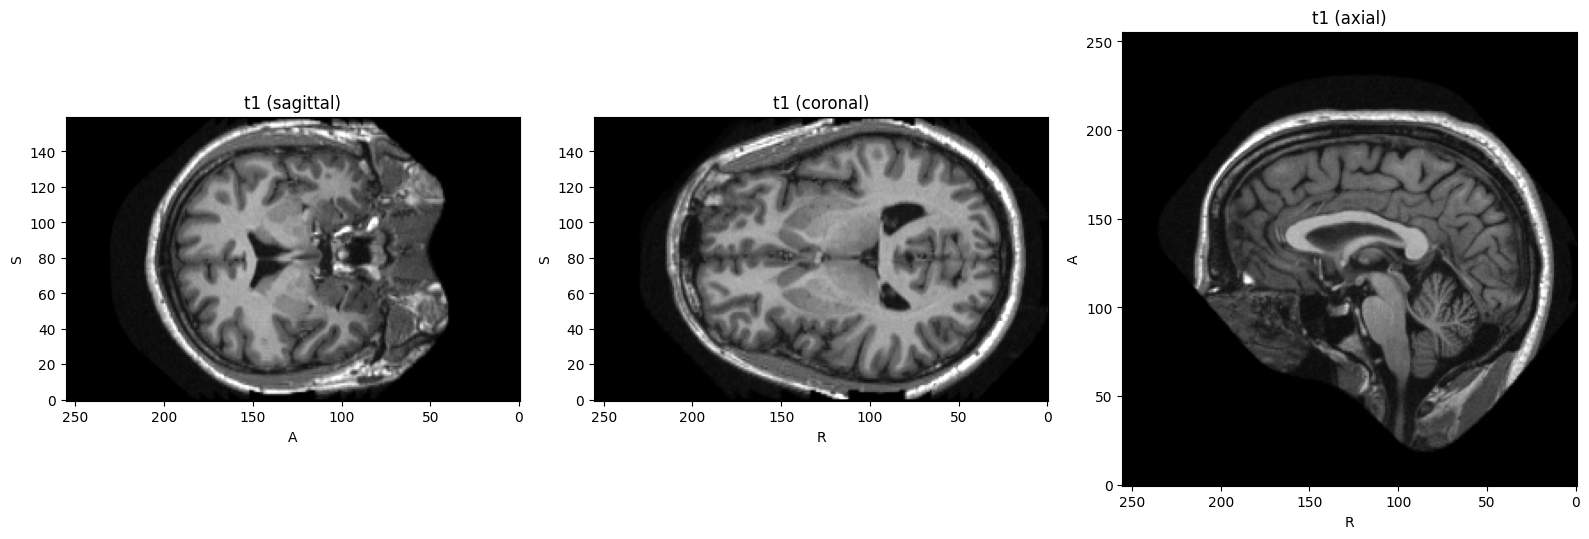

In [6]:
subject.plot()

The anatomical labels are incorrect because the `plot` method expects an image in [RAS+ orientation](https://nipy.org/nibabel/image_orientation.html), or reorients it if `reorient` is `True`. It was a good idea to add `ToCanonical` to our list of preprocessing transforms, as it reorients the image to RAS+.

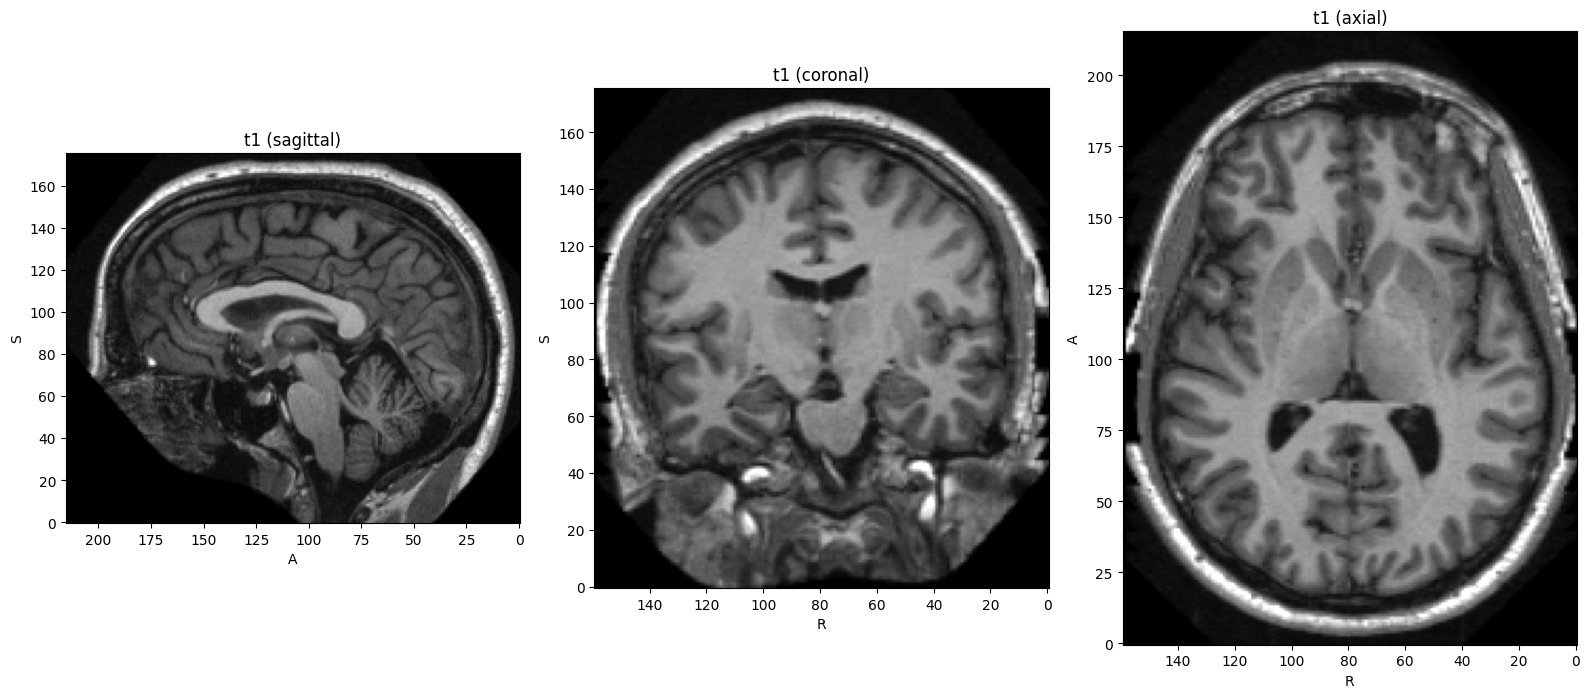

In [7]:
preprocessed.plot()

## Pretrained model

We will use the wonderful [PyTorch Hub](https://pytorch.org/hub/) to download the pretrained model from GitHub:

In [8]:
repo = 'fepegar/highresnet'
model_name = 'highres3dnet'
model = torch.hub.load(repo, model_name, pretrained=True, trust_repo=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
model.to(device).eval();

Using cache found in /root/.cache/torch/hub/fepegar_highresnet_master


Device: cuda


## Inference


In [9]:
# Some tools for visualization
class ColorMapHelper:
    def __init__(self, colors_path):
        columns = 'name', *'rgba'
        df = pd.read_csv(colors_path, sep=' ', header=None, index_col=0, names=columns)
        max_index = max(df.index)
        self.cmap_data = np.zeros((max_index + 1, 4))
        df[['r', 'g', 'b', 'a']] = df[['r', 'g', 'b', 'a']] / 255
        self.cmap_data[df.index] = df[['r', 'g', 'b', 'a']].values
        self.cmap_data[:, 3] = 1
        self.cmap = ListedColormap(self.cmap_data)
helper = ColorMapHelper('GIFNiftyNet.ctbl')
cmap = helper.cmap
cmap_dict = {}

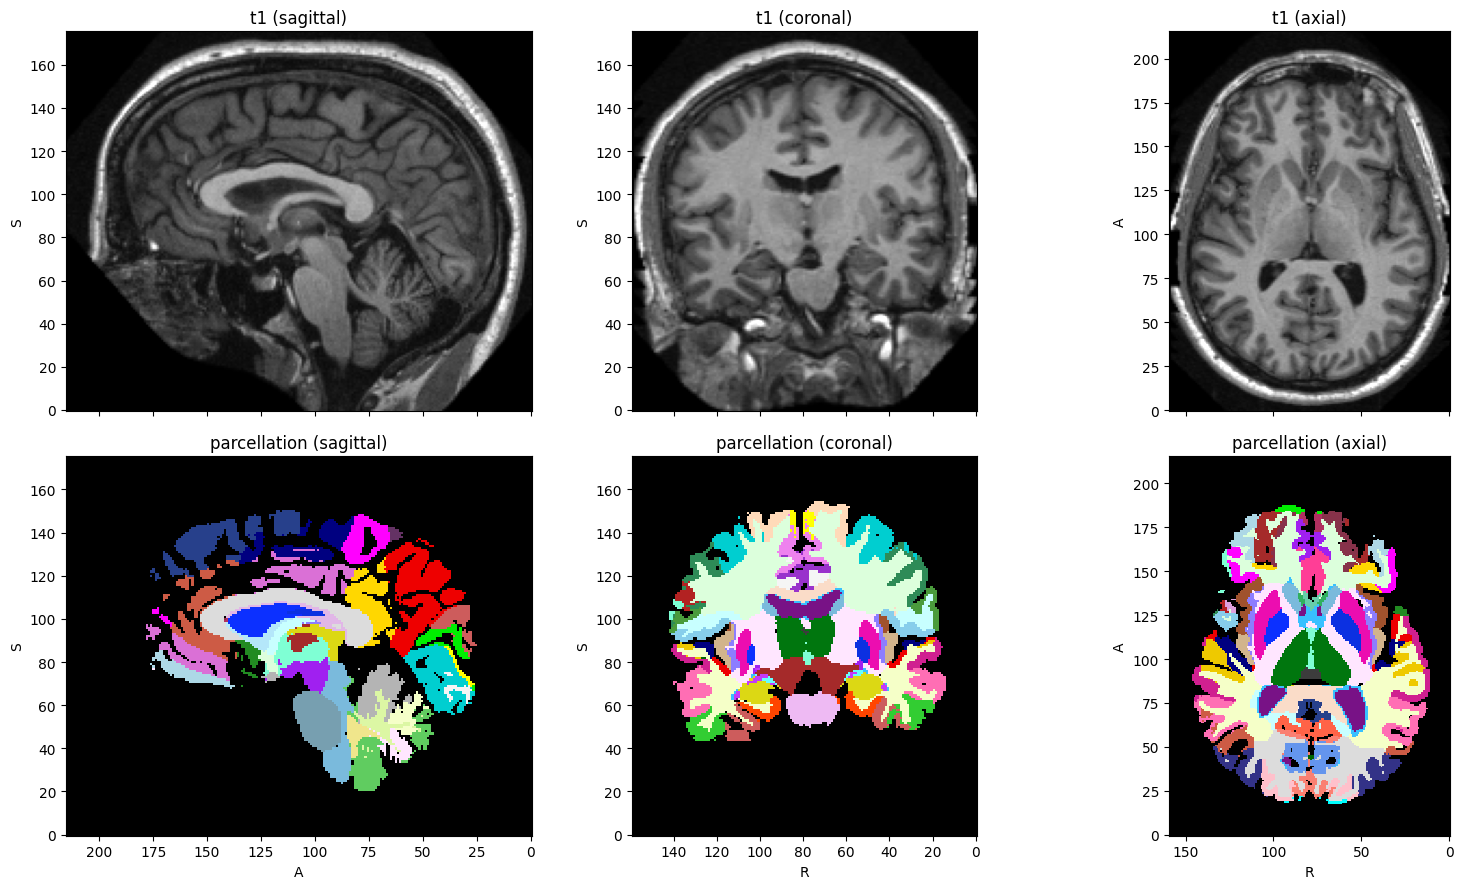

In [10]:
input_tensor = preprocessed.t1.data[np.newaxis].to(device)  # add batch dim
with torch.autocast(device.type):
    logits = model(input_tensor)
full_volume_output_tensor = logits.argmax(dim=tio.CHANNELS_DIMENSION, keepdim=True).cpu()[0]  # get first along batch dim
seg = tio.LabelMap(tensor=full_volume_output_tensor, affine=preprocessed.t1.affine)
name = 'parcellation'
preprocessed.add_image(seg, name)
cmap_dict[name] = cmap
preprocessed.plot(cmap_dict=cmap_dict)

Since the image might be too large for the available GPU, we could [perform inference using image patches](https://torchio.readthedocs.io/data/patch_based.html) instead.

We will use a [`GridSampler`](https://torchio.readthedocs.io/data/patch_inference.html#grid-sampler) to extract patches from all the necessary locations in the image. `GridSampler` is a subclass of [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), so we can easily extract batches of patches using a [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader).

We will add a small overlap between patches to avoid the border effect.

  0%|          | 0/8 [00:00<?, ?batch/s]

<ipython-input-11-1325924b7416>:19: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  patchwise_output_tensor = aggregator.get_output_tensor()


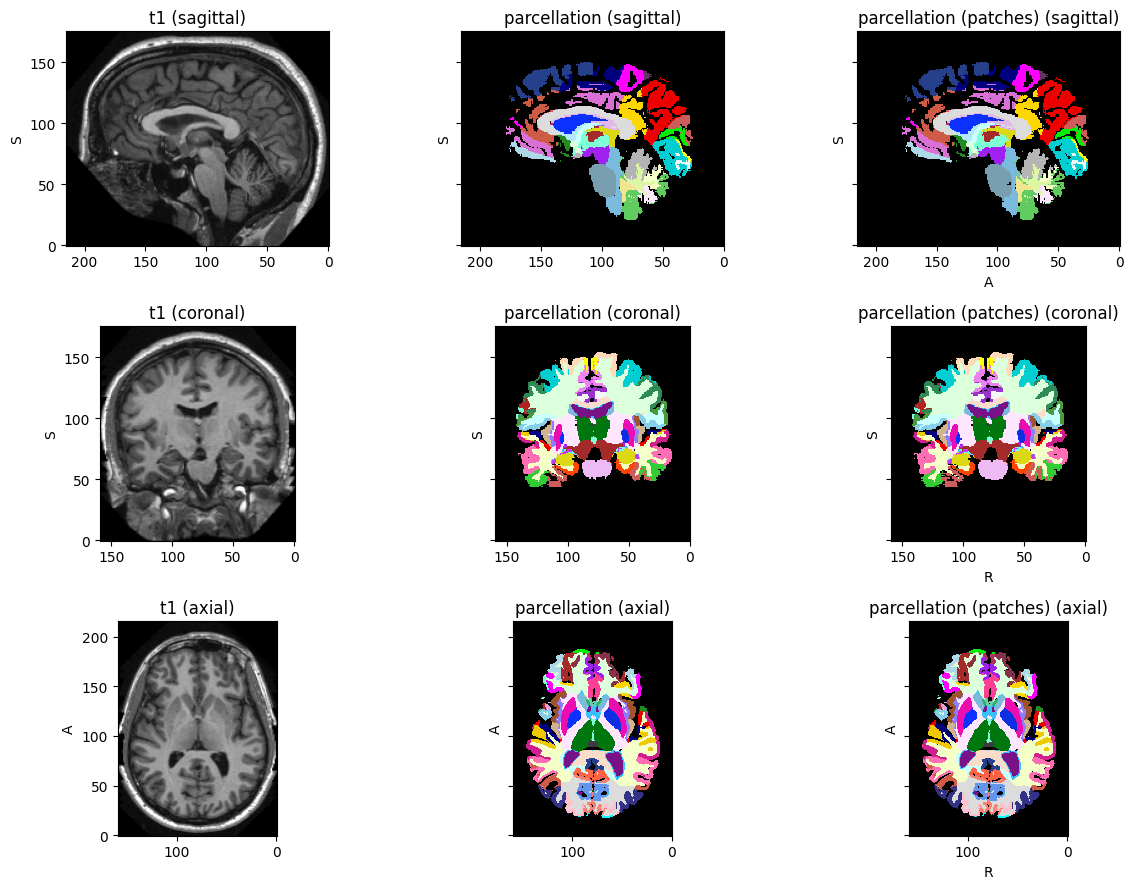

In [11]:
patch_overlap = 4
patch_size = 128
grid_sampler = tio.inference.GridSampler(
    preprocessed,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(grid_sampler)
aggregator = tio.inference.GridAggregator(grid_sampler)
preprocessed.clear_history()  # so that image is not padded when inverting cropping later on

for patches_batch in tqdm(patch_loader, unit='batch'):
    input_tensor = patches_batch['t1'][tio.DATA].to(device)
    locations = patches_batch[tio.LOCATION]
    with torch.autocast(device.type):
        logits = model(input_tensor)
    labels = logits.argmax(dim=tio.CHANNELS_DIMENSION, keepdim=True)
    aggregator.add_batch(labels, locations)
patchwise_output_tensor = aggregator.get_output_tensor()
seg = tio.LabelMap(tensor=patchwise_output_tensor, affine=preprocessed.t1.affine)
name = 'parcellation (patches)'
preprocessed.add_image(seg, name)
cmap_dict[name] = cmap
preprocessed.plot(cmap_dict=cmap_dict)

The result is not as good as a full [GIF](https://spiral.imperial.ac.uk/bitstream/10044/1/30755/4/07086081.pdf) or [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all) parcellation but hey, it's 600 times faster and takes very little GPU VRAM!

## Test-time augmentation and uncertainty estimation

[Test-time augmentation (TTA)](https://www.nature.com/articles/s41598-020-61808-3) can be used to improve the results. We will apply some transform to the image, infer the segmentation on the transformed space and apply the inverse transform to bring the image to the result to the original space. Then, we can use majority voting to obtain a more robust segmentation result.

In [12]:
def get_lr_remapping(table_path):
    import pandas as pd
    df = pd.read_csv(table_path, sep=' ', names=['Label', 'Name', *'RGBA'])
    mapping = {}
    for row in df.itertuples():
        if 'Left' in row.Name:
            mapping[row.Label] = df[df.Name == f'Right-{row.Name[5:]}'].Label.values[0]
        elif 'Right' in row.Name:
            mapping[row.Label] = df[df.Name == f'Left-{row.Name[6:]}'].Label.values[0]
    return mapping

In [13]:
num_augmentations = 20 if device.type == 'cuda' else 3
results = []
remapping = get_lr_remapping('GIFNiftyNet.ctbl')

# If the image is flipped, labels should be changed accordingly
flip = tio.Compose((
        tio.RandomFlip(axes=['LR'], flip_probability=1),
        tio.RemapLabels(remapping),
    ),
    p=0.5,
)
affine = tio.RandomAffine(image_interpolation='nearest')
augment = tio.Compose((flip, affine))
for _ in trange(num_augmentations):
    augmented = augment(preprocessed)
    input_tensor = augmented.t1.data[None].to(device)
    with torch.autocast(device.type):
        logits = model(input_tensor)
    output_tensor = logits.argmax(dim=1, keepdim=True).cpu()
    label_map = tio.LabelMap(tensor=output_tensor[0], affine=augmented.t1.affine)
    name = 'label'
    augmented.add_image(label_map, name)
    back = augmented.apply_inverse_transform(warn=True)
    results.append(back[name].data)
result = torch.stack(results).long()

  0%|          | 0/20 [00:00<?, ?it/s]

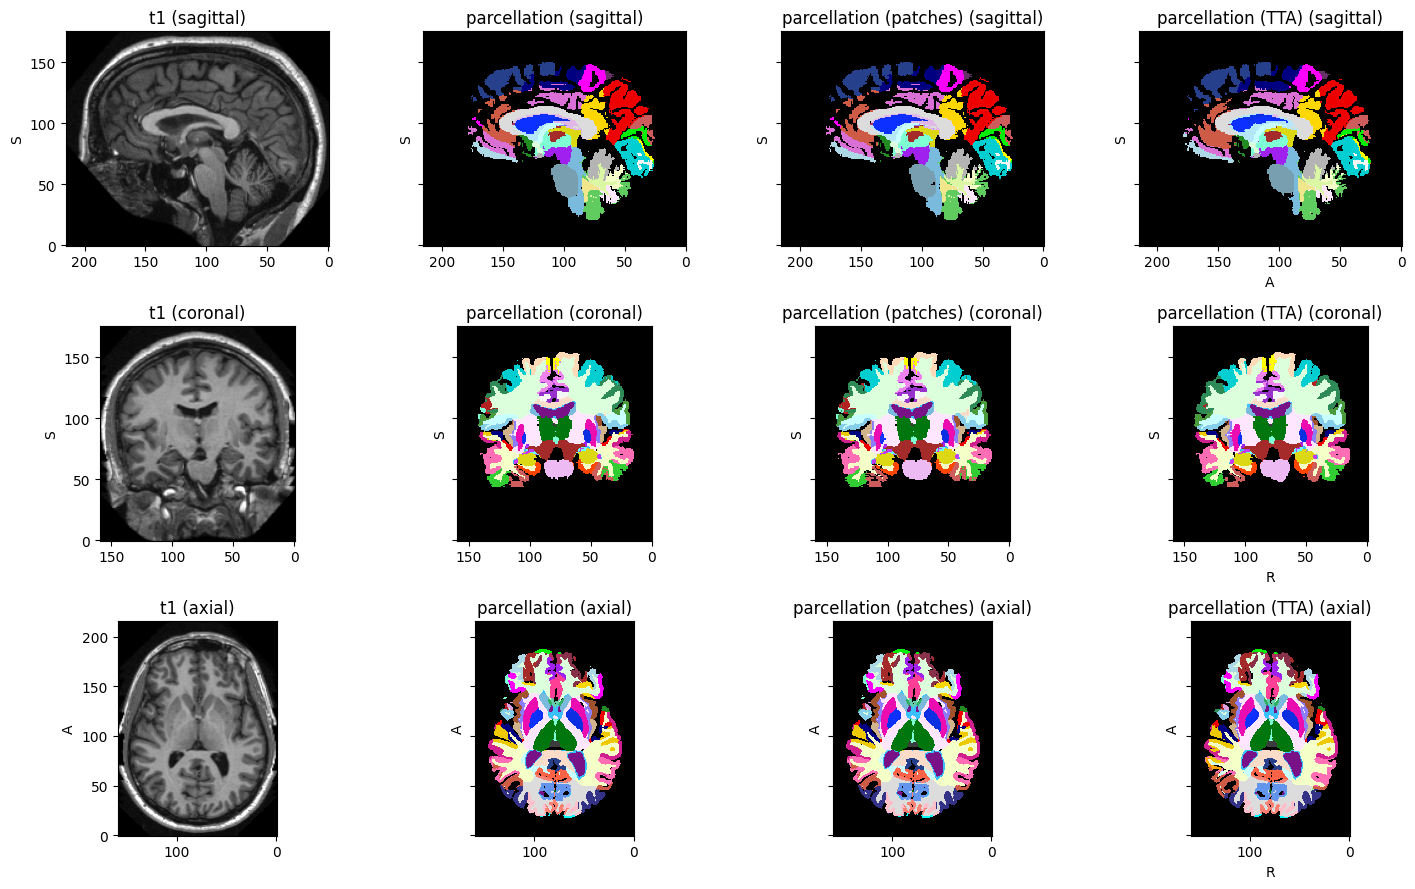

In [14]:
tta_result_tensor = result.mode(dim=0).values  # majority voting
seg = tio.LabelMap(tensor=tta_result_tensor, affine=preprocessed.t1.affine)
name = 'parcellation (TTA)'
preprocessed.add_image(seg, name)
cmap_dict[name] = cmap
preprocessed.plot(cmap_dict=cmap_dict)

The result using TTA should be more robust.

### Voxel-wise aleatoric uncertainty estimation

We can [estimate the vocel-wise aleatoric uncertainty](https://www.sciencedirect.com/science/article/pii/S0925231219301961) using our multiple results. We will use the technique from [Li et al.](https://link.springer.com/chapter/10.1007/978-3-319-59050-9_28): the uncertainty at each voxel is the percentage of predictions different to the most frequent prediction during our TTA.

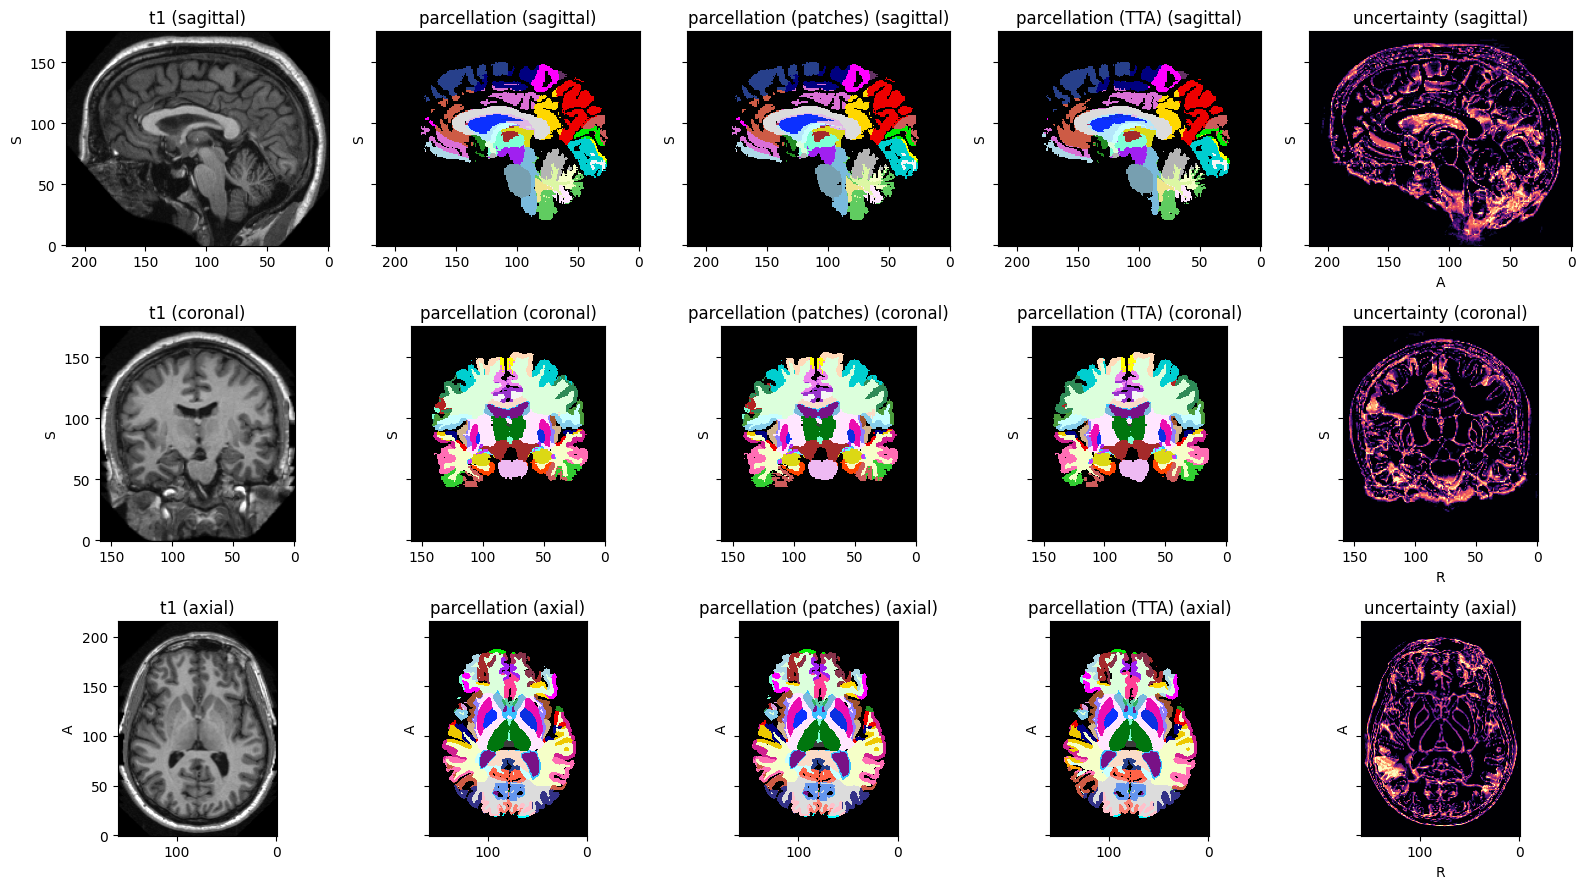

In [15]:
different = torch.stack([
    tensor != tta_result_tensor
    for tensor in results
])
uncertainty = different.float().mean(dim=0)
uncertainty_img = tio.ScalarImage(tensor=uncertainty, affine=preprocessed.t1.affine)
name = 'uncertainty'
preprocessed.add_image(uncertainty_img, name)
cmap_dict[name] = 'magma'
preprocessed.plot(cmap_dict=cmap_dict)

As expected, the highest uncertainty values are in voxels on the boundaries between brain structures.

## Conclusion

We have seen how to combine TorchIO and PyTorch hub to infer a full brain parcellation using patches of a 3D T1-weighted MRI and a pre-trained convolutional neural network, or the full volume.

We have also used TorchIO to perform test-time augmentation and estimate a voxel-wise aleatoric uncertainty of our prediction.

TorchIO is looking for feedback and contributors. Don't hesitate to [open an issue](https://github.com/fepegar/torchio/issues/new/choose) in the repository with questions or feature requests!